In [10]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

import matplotlib.pyplot as plt

from collections import OrderedDict

import pandas as pd
import seaborn as sns

from tqdm import tqdm

In [35]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

def get_model(dim_z: int, batch_size=128, less_than=10):

  # Download training data from open datasets.
  training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
  )

  training_data.data = training_data.data[training_data.targets < less_than]
  training_data.targets = training_data.targets[training_data.targets < less_than]

  # Create data loaders.
  dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

  encoder = nn.Sequential(
    nn.Linear(784, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 64),
    nn.Tanh(),
    nn.Linear(64, dim_z),
  )

  decoder = nn.Sequential(
    nn.Linear(2, 64),
    nn.Tanh(),
    nn.Linear(64, 128),
    nn.Tanh(),
    nn.Linear(128, 512),
    nn.Tanh(),
    nn.Linear(512, 784),
    nn.Sigmoid(),
  )

  model = nn.Sequential(OrderedDict([
            ('encoder', encoder),
            ('decoder', decoder),
          ]))

  optimizer = torch.optim.Adam(model.parameters())

  return model, dataloader, optimizer

In [36]:
def train(model, dataloader, optimizer, run, epochs=5):
  
  model.to(device)
  model.train()

  hist = torch.zeros(0)

  for _ in tqdm(range(epochs)):
    tmp = run(model, dataloader, optimizer)
    hist = torch.cat([hist, tmp])
  
  return hist

In [12]:
def run_for_one_point(model, dataloader, optimizer):

  hist = torch.zeros(len(dataloader))
  
  ps = torch.tensor([[0, 0]]).to(device)
  
  for batch, (x, y) in enumerate(dataloader):
    x = x.view([-1, 28*28]).to(device)

    # Compute prediction error
    z = model.get_submodule('encoder')(x)
    dist = (z - ps).square().sum(dim=1).mean()
    pred = model.get_submodule('decoder')(z)
    likelihood = (x*pred.log() + (1 - x)*(1 - pred).log()).sum(dim=[1]).mean()
    loss = -likelihood + dist

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    hist[batch] = loss.item()

  return hist

In [21]:
model, dataloader, optimizer = get_model(dim_z=2)
hist = train(model, dataloader, optimizer, run=run_for_one_point, epochs=30)

100%|██████████| 30/30 [02:56<00:00,  5.87s/it]


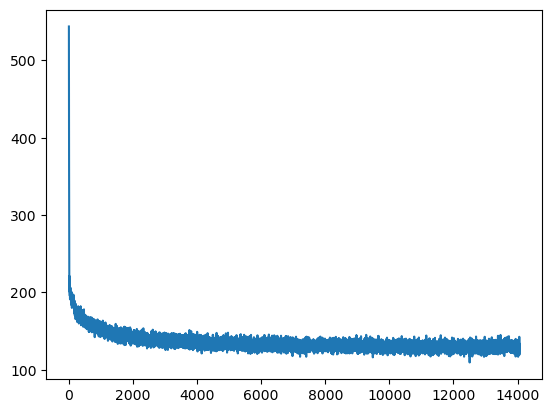

In [22]:
plt.plot(hist)
plt.show()

<AxesSubplot:xlabel='x', ylabel='y'>

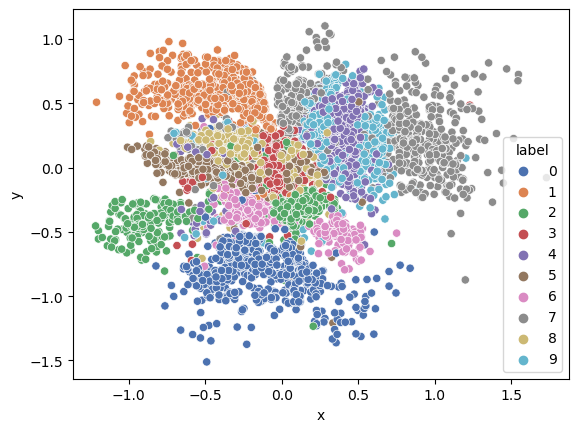

In [23]:
df = pd.DataFrame(columns=['x', 'y', 'label'])

model.to('cpu')

with torch.no_grad():
  idx = 0
  for x, y in train_dataloader:
    x = x.reshape([-1, 28*28])
    z = model.get_submodule('encoder')(x)
    
    tmp = pd.DataFrame(
      {
        'x': z[:, 0],
        'y': z[:, 1],
        'label': y
      }
    )
    df = pd.concat([df, tmp], ignore_index=True)

    idx += 1
    if idx > 50:
      break

sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")

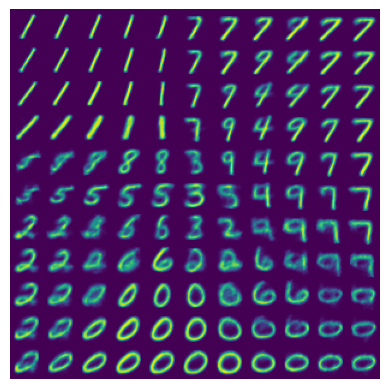

In [24]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-1, 1, 11), torch.linspace(-1, 1, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    tmps = decoder(r).view([-1, 1, 28, 28])
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

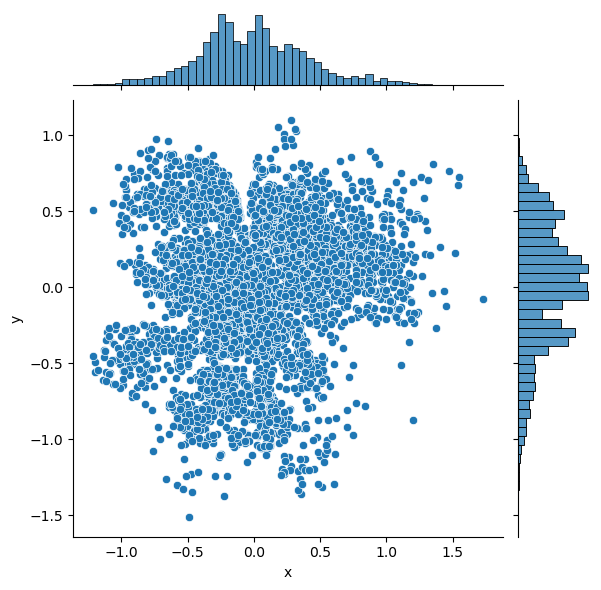

In [25]:
sns.jointplot(data=df, x="x", y="y")

100%|██████████| 30/30 [03:46<00:00,  7.56s/it]


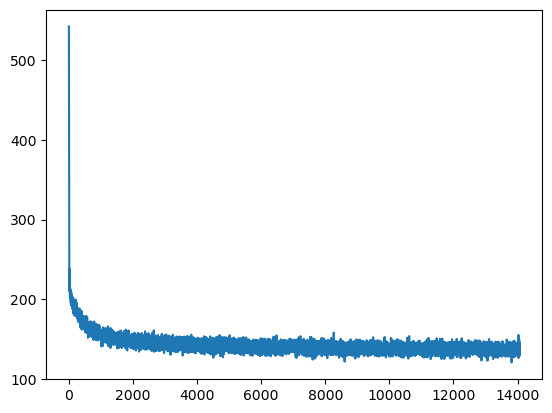

In [37]:
def run_for_vae(model, dataloader, optimizer):

  hist = torch.zeros(len(dataloader))

  model.train()
  for batch, (x, y) in enumerate(dataloader):
    x = x.view([-1, 28*28]).to(device)

    # Compute prediction error
    h = model.get_submodule('encoder')(x)
    sigma = F.softplus(h[:, 2:]) + 1e-6
    mu = h[:, :2]
    sampled_h = torch.randn([h.shape[0], 2]).to(device) * sigma + mu
    kld = (0.5 * (mu.square() + sigma.square() - sigma.square().log() - 1)).sum(dim=1).mean()
    pred = model.get_submodule('decoder')(sampled_h)
    likelihood = (x*pred.log() + (1 - x)*(1 - pred).log()).sum(dim=[1]).mean()
    loss = -likelihood + kld

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    hist[batch] = loss.item()

  return hist

model_1, dataloader, optimizer = get_model(dim_z=4)
hist = train(model_1, dataloader, optimizer, run=run_for_vae, epochs=30)

plt.plot(hist)
plt.show()

<AxesSubplot:xlabel='x', ylabel='y'>

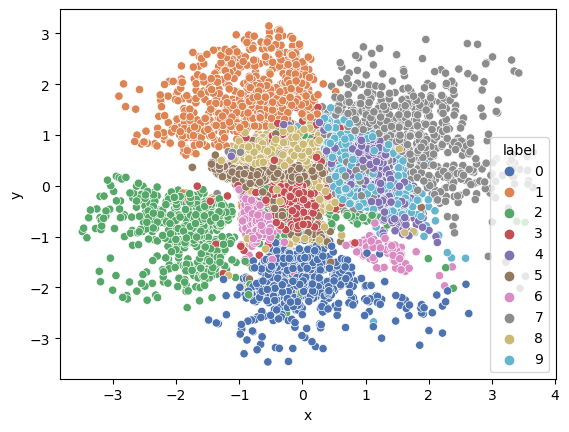

In [42]:
df = pd.DataFrame(columns=['x', 'y', 'label'])

model_1.to('cpu')

with torch.no_grad():
  idx = 0
  for x, y in train_dataloader:
    x = x.reshape([-1, 28*28])
    h = model_1.get_submodule('encoder')(x)
    z = h[:, :2]
    
    tmp = pd.DataFrame(
      {
        'x': z[:, 0],
        'y': z[:, 1],
        'label': y
      }
    )
    df = pd.concat([df, tmp], ignore_index=True)

    idx += 1
    if idx > 50:
      break

sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")

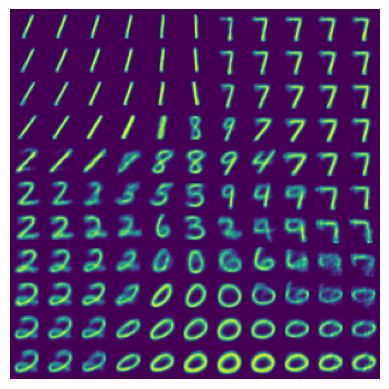

In [45]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-3, 3, 11), torch.linspace(-3, 3, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    tmps = decoder(r).view([-1, 1, 28, 28])
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)

with torch.no_grad():
  plot_reconstructed(model_1.get_submodule('decoder'), points)
  

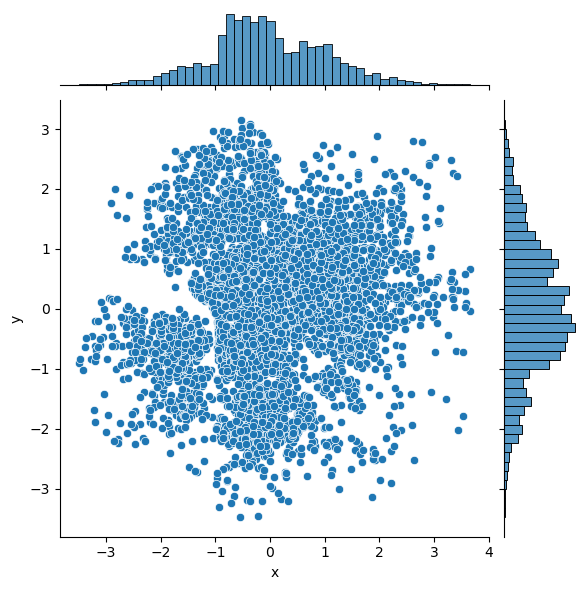

In [46]:
sns.jointplot(data=df, x="x", y="y")

In [47]:
!nvidia-smi

Fri Jun 16 10:52:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:65:00.0 Off |                    0 |
| N/A   38C    P0    62W / 300W |  79895MiB / 81920MiB |      2%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:B3:00.0 Off |                    0 |
| N/A   